In [1]:
%load_ext lab_black

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima

In [3]:
data = pd.read_csv("../data/combined.csv").set_index("date")

In [4]:
gas_price = data["gas_price"]

lin1 = gas_price + (gas_price - gas_price.shift(1))
lin10 = gas_price + (gas_price - gas_price.shift(10)) / 10

In [5]:
def ols(y):
    window = len(y)
    x = np.linspace(0, window, window)
    stdx = np.std(x)
    stdx = stdx if stdx else 1
    stdy = np.std(y)
    r = np.corrcoef(y)
    beta1 = r * stdy / stdx
    beta0 = np.mean(y) - beta1 * np.mean(x)

    return beta0 + beta1 * (window + 1)


ols10 = gas_price.rolling(window=10, min_periods=2).apply(ols)

In [6]:
arima_df = data.copy()
arima_df["gas_price"] = arima_df["gas_price"].shift(1).bfill()

train = arima_df.loc[:"2019-01-01"]
test = arima_df.loc["2019-01-01":]

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    arima = auto_arima(
        train["gas_price"],
        X=train[[col for col in data.columns if col != "gas_price"]],
        start_p=0,
        start_q=0,
        max_p=30,
        max_q=30,
        d=0,
        trace=True,
    )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1661.470, Time=2.57 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3389.401, Time=2.57 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2388.133, Time=3.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6674.907, Time=2.33 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3399.579, Time=3.33 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-3397.636, Time=3.88 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3397.547, Time=3.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3399.388, Time=3.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3395.949, Time=4.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3401.587, Time=3.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3391.409, Time=2.48 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3399.646, Time=3.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3399.558, Time=3.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3401.400, Time=2.81 sec
 ARIMA(3,0,1)(0,0,0)

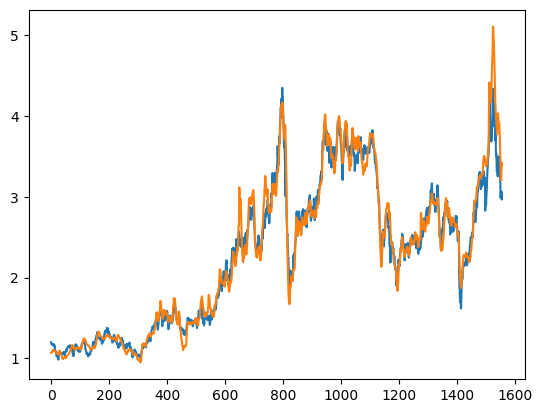

In [7]:
arima_pred = arima.predict(
    n_periods=len(arima_df),
    X=arima_df[[col for col in data.columns if col != "gas_price"]],
)

plt.plot(arima_pred.values)
plt.plot(data["gas_price"].values)

In [8]:
predictive = {
    "short_linear_projection": lin1,
    "long_linear_projection": lin10,
    "arima": arima_pred.values,
}

predictive = pd.DataFrame(predictive).bfill()

In [9]:
predictive.to_csv("../data/predictive_features.csv")

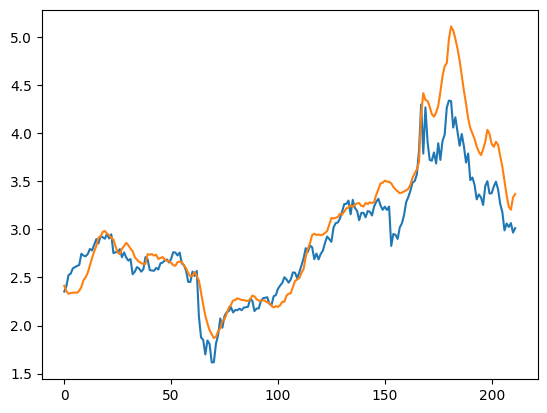

In [10]:
arima_pred = arima.predict(
    n_periods=len(test),
    X=test[[col for col in data.columns if col != "gas_price"]],
)

plt.plot(arima_pred.values)
plt.plot(test["gas_price"].values)